## Monitoring socio-economic activities with nighttime light maps
### Case study: Creating nighttime light maps with color blending

This notebook demonstrates how to create nighttime light variation maps over a time interval (from 2019 to 2022) with additive color blending for studying the distribution of artificial lighting in urban and rural regions, offering insights into urbanization, infrastructure development, and socio-economic activity.
The Nighttime Light Levels indicator can be explored on the EO Dashboard by selecting the EXPLORE DATASETS mode and choosing [Night lights indicators](https://eodashboard.org/explore?indicator=NTLU&x=12142837.23019&y=4137471.98879&z=5.69238). 

The study has been carried out by **Bumpei Tojo PhD (Associate Professor), School of International and Area Studies, Tokyo University of Foreign Studies, Japan**.

The **PLES Engineering team** (supporting *ESA Green Solutions Division*, EOP-SG) developed the blending algorithm with the current Notebook implementation and data ingestion on the dashboard (contacts: **Federico Rondoni**, f.rondoni@stariongroup.eu, **Diego Moglioni**, d.moglioni@stariongroup.eu).  

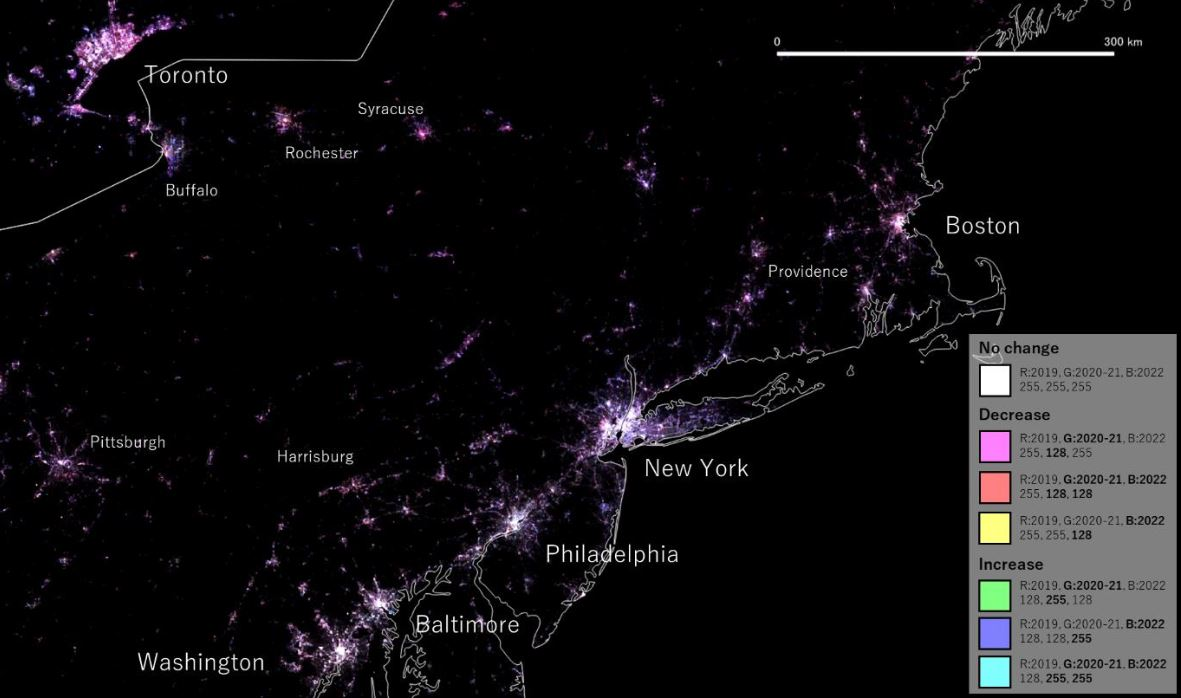
Example of a nighttime light map covering Northeastern United States during 2019-2022, representing areas where a decrease in nighttime light level occurred (indicating a presumed reduction in social activity) in red, and areas where an increase occurred (indicating a presumed increase in social activity) in blue.

### Input data:
* This product was developed by JAXA by aggregating the data from the Visible Infrared Imaging Radiometer Suite (VIIRS, onboard the Suomi NPP satellite) on a semi-annual basis (using median image generation) with 10-degree lat/lon (geographic) grid h-v tile as Geo Tiff files.
* The tiles are 2400 x 2400 pixels, with pixel size of 0.004166 degrees (~464 m at the equator).
* Metric: nighttime radiance (measured in watts per square centimeter per steradian, [W/cm²/sr]), which represents the brightness of artificial lighting.

**VIIRS 10-degree tile scheme**

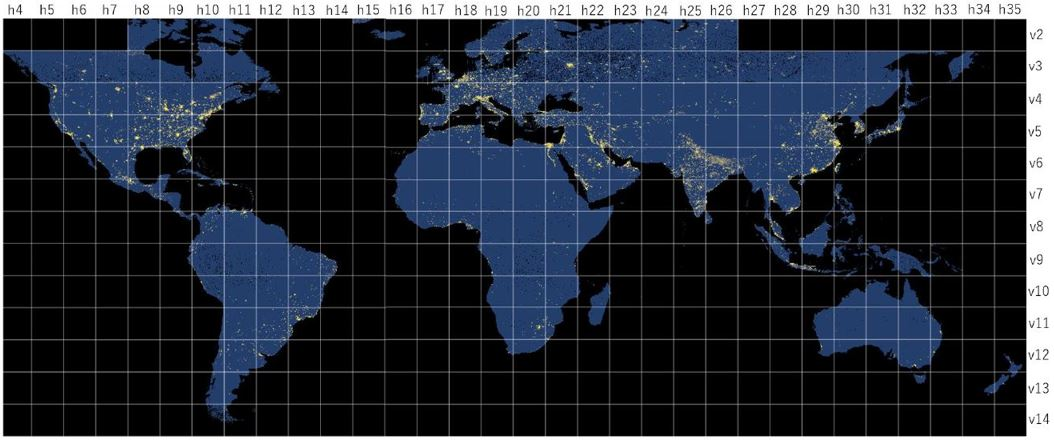



### Running environment:
* This notebook can be run by installing the provided Anaconda Python environment (data/Nightlights/**nightlights-env.yml**).

### Importing Python libraries

In [4]:
#Import libraries
import os
import sys
import re
import numpy as np
import rasterio
import rioxarray as rxr
import subprocess
from subprocess import Popen, PIPE
import tempfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import json
from ipyleaflet import Map, ImageOverlay, basemaps

### Defining working folders

In [5]:
input_dir = "input"
input_path = os.path.join(os.getcwd(), "data", "Nightlights", input_dir)

output_urban = "output"
urban_path = os.path.join(os.getcwd(), "data", "Nightlights", output_urban)

# Create output dir
os.makedirs(urban_path, exist_ok=True)

### Visualizing input data

In [6]:
pattern = re.compile(r"h(\d+)v(\d+)_(\d{4})_(\d)H_median\.tif")

for root, _, files in os.walk(input_path):
    grouped_files = {}
    
    # Grouping files by h and v
    for file in files:
        match = pattern.match(file)
        if match:
            h, v, year, H = match.groups()
            key = (h, v)
            if key not in grouped_files:
                grouped_files[key] = []
            grouped_files[key].append((year, H, os.path.join(root, file))) 
    
    # Process files for plotting
    for (h, v), file_group in grouped_files.items():
        file_group

tuplelist2dict = {c:{'year':a,'half':b} for a,b,c in file_group}
sorted_dict = {}

grid_tile = None
for item in sorted(tuplelist2dict, key = lambda k: (tuplelist2dict[k]['year'], tuplelist2dict[k]['half'])):
    sorted_dict.update({item:tuplelist2dict[item]})
    grid_tile = item.split('/')[-1].split('_')[0]


In [7]:
def plot_figures(figures, nrows = 1, ncols=1, factor = 1., clip_range = None, **kwargs):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))
    for idx,file_name in enumerate(figures):
        title = file_name.split('/')[-1]
        title = title.replace("_median.tif", "")
        axeslist.ravel()[idx].imshow(np.clip(mpimg.imread(file_name)*factor, *clip_range), **kwargs) # cmap=plt.gray(), cmap='Greys'
        axeslist.ravel()[idx].set_title(title)
        axeslist.ravel()[idx].set_axis_off()
    fig.suptitle(r'Median nighttime light level [$Wcm^{-2}sr^{-1}$]', fontsize=20)
    #plt.tight_layout() 

    

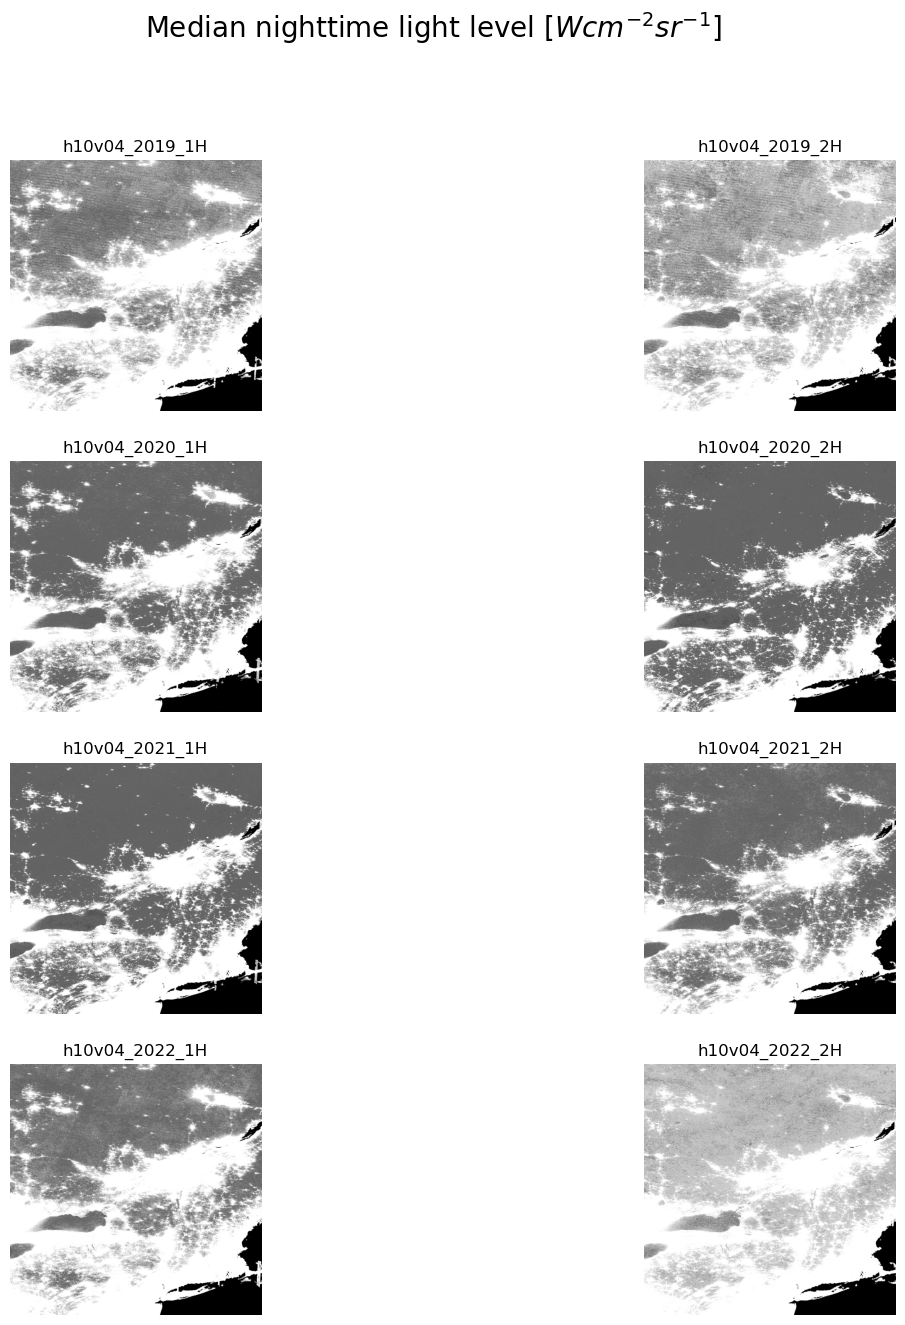

In [8]:
plot_figures(sorted_dict, 4, 2, clip_range=(0,1), factor=100./255.)

### Applying color blending 

Additive color blending involves mixing the primary colors of light, red (R), green (G), and blue (B), while adjusting their luminance levels. By manipulating the luminance of these colors, a wide range of hues can be achieved, with the key characteristic being that combining all three colors results in white.

Technique
- maximum pixel value of images for 2019 (brightest pixel values) is assigned to red (R)
- minimum pixel value of images for 2020-2021 (darkest pixel values) is assigned to green (G)
- maximum pixel value of images for 2022 (brightest pixel values) is assigned to blue (B)

Output
- regions where a decrease in nighttime light level occurred are displayed in red
- areas that experienced an increase (presumed to indicate an increase in social activity) are shown in blue
- regions where there was no significant change throughout the pandemic are displayed in a gradient from gray to white.

In [73]:
pattern = re.compile(r"h(\d+)v(\d+)_(\d{4})_(\d)H_median\.tif")


def read_and_preprocess(file):
    with rasterio.open(file) as src:
        img = src.read(1)
        img = np.nan_to_num(img, nan=0)  # Replace NaNs with zeros
        return img, src.profile

    
def additive_blending(grouped_files):
    # Process each group of files for blending
    for (h, v), file_group in grouped_files.items():
        # Initialize arrays to store the maximum and minimum values for each year
        max_2019 = None
        min_2020_2021 = None
        max_2022 = None
        
        for year, H, file in file_group:
            img, profile = read_and_preprocess(file)
            
            if year == '2019':
                if max_2019 is None:
                    max_2019 = img
                else:
                    max_2019 = np.maximum(max_2019, img)
            elif year in ['2020', '2021']:
                if min_2020_2021 is None:
                    min_2020_2021 = img
                else:
                    min_2020_2021 = np.minimum(min_2020_2021, img)
            elif year == '2022':
                if max_2022 is None:
                    max_2022 = img
                else:
                    max_2022 = np.maximum(max_2022, img)
                                  
    # Create the blended image using the specified blending technique
    blended_img = np.zeros((max_2019.shape[0], max_2019.shape[1], 3), dtype=np.float32)
    blended_img[:, :, 0] = max_2019.astype(np.float32)  # Red band: maximum of 2019
    blended_img[:, :, 1] = min_2020_2021.astype(np.float32)  # Green band: minimum of 2020-2021 compared
    blended_img[:, :, 2] = max_2022.astype(np.float32)  # Blue band: maximum of 2022
    
    return blended_img, profile        

In [75]:
# Grouping files per (h,v) tiles and years span
grouped_files = {}
for root, _, files in os.walk(input_path):
    
    
    # Group files by h and v
    for file in files:
        match = pattern.match(file)
        if match:
            h, v, year, H = match.groups()
            key = (h, v)
            if key not in grouped_files:
                grouped_files[key] = []
            grouped_files[key].append((year, H, os.path.join(root, file)))


# blending           
blended_img, profile = additive_blending(grouped_files)

### Employing "urban" stretch processing

The purpose of the stretch processing is to emphasize the nighttime light level of each band (corresponding to 2019, 2020-21, and 2022), focusing on:
- "urban" nighttime light levels: the display range of each band is adjusted to 25-1000 [watts·cm-2·sr-1], emphasizing brighter areas

In [76]:
# Urban stretch processing: Emphasize brighter areas
def urban_stretch_processing(band):
    min_val = 25
    max_val = 1000
    band = np.clip(band, min_val, max_val)
    band = (band - min_val) / (max_val - min_val) * 255
    return band.astype(np.uint8)

# Apply urban stretch processing to each band
blended_img[:, :, 0] = urban_stretch_processing(blended_img[:, :, 0])
blended_img[:, :, 1] = urban_stretch_processing(blended_img[:, :, 1])
blended_img[:, :, 2] = urban_stretch_processing(blended_img[:, :, 2])
        
# Update the profile for a 3-band image and set nodata value to None
profile.update(count=3, dtype=rasterio.uint8, nodata=None)

### Plotting blended image

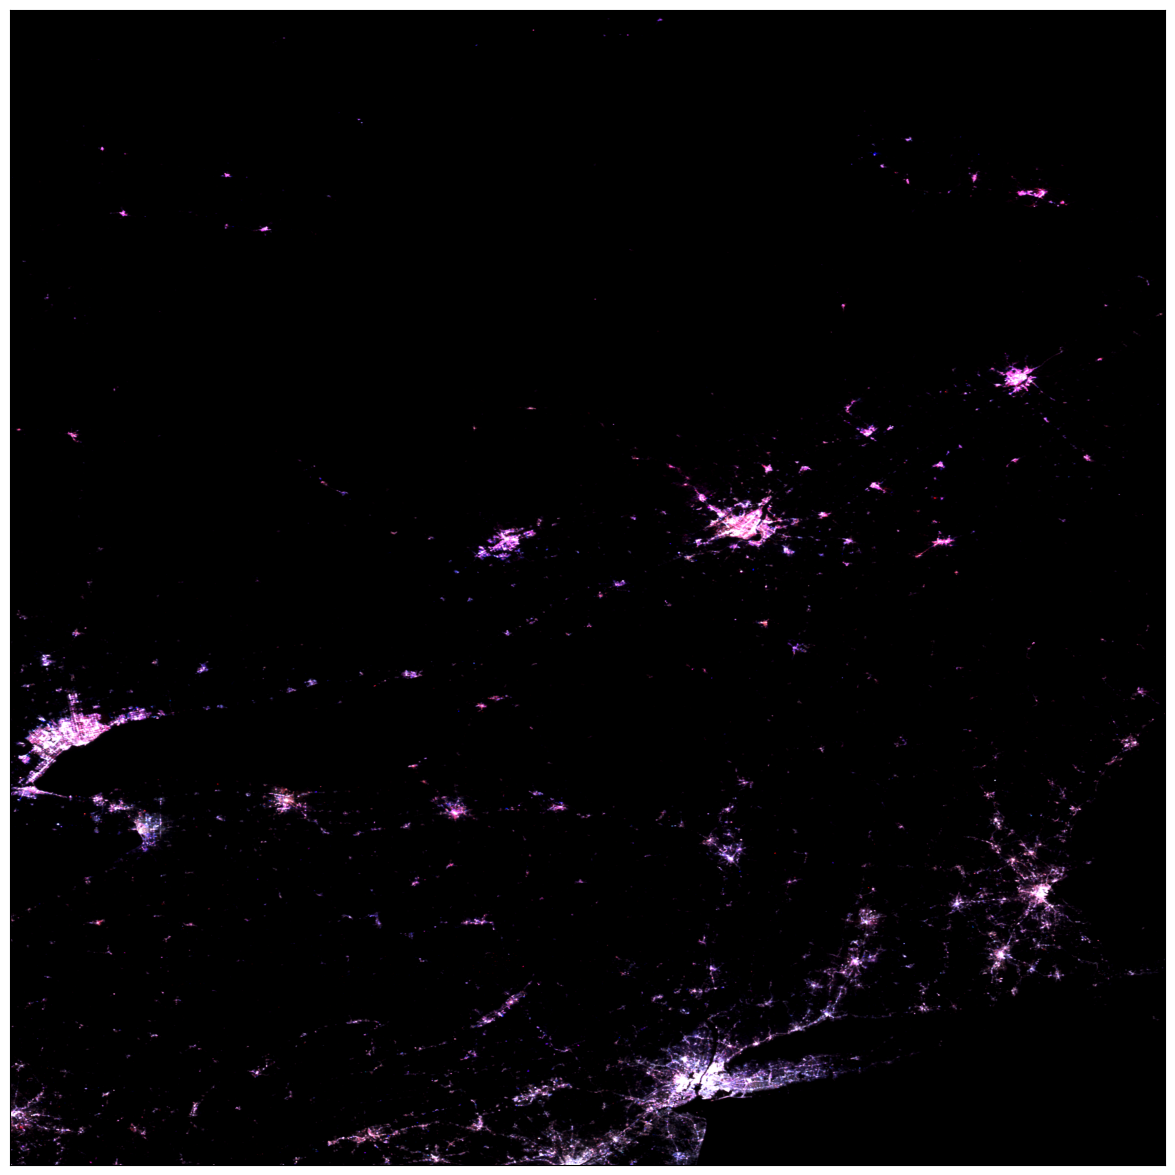

In [77]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])


plot_image(blended_img, factor=1.5/255., clip_range=(0,1))

### Overlaying with an interactive map

Saving blended image as Cloud Optimized GeoTIFF

In [78]:
# Exporting output as COG file 
res_name = f"Nighttimelevel_Urban_{grid_tile}_2019-2022.tif"
output_cog = os.path.join(output_urban, res_name)


# Write the blended image directly to a temporary file
with tempfile.NamedTemporaryFile(suffix=".tif") as temp_file:
    with rasterio.open(temp_file.name, "w", **profile) as dst:
        dst.write(blended_img[:, :, 0], 1)
        dst.write(blended_img[:, :, 1], 2)
        dst.write(blended_img[:, :, 2], 3)

    subprocess.run([
        "gdal_translate", "-of", "COG",
        "-co", "COMPRESS=DEFLATE",
        "-co", "BLOCKSIZE=512",
        "-co", "RESAMPLING=NEAREST",
        "-co", "OVERVIEWS=IGNORE_EXISTING",
        temp_file.name,
        output_cog
    ])

print(f"COG file saved as {output_cog}")

Input file size is 2400, 2400
0...10...20...30...40...50...60...70...80...90...100 - done.
COG file saved as out_urban/Nighttimelevel_Urban_h10v04_2019-2022.tif


Extracting bounding-box coordinates

In [79]:
p1 = Popen(["gdalinfo", "-json", output_cog, "-mm"], stdout=PIPE)
output = p1.communicate()[0]
dec_out = output.decode('utf-8')
j_str = json.loads(dec_out)
bbox = j_str['cornerCoordinates']
ll = bbox['lowerLeft']  # SW coo
ur = bbox['upperRight'] # NE coo
center = bbox['center']

Adding alpha channel to the blended image 

In [80]:
def almostEquals(a,b,thres=50):
    return all(abs(a[i]-b[i])<thres for i in range(len(a)))


image = Image.open(output_cog).convert('RGBA')
pixeldata = list(image.getdata())


for i,pixel in enumerate(pixeldata):
    if almostEquals(pixel[:3], (0,0,0)):
        pixeldata[i] = (0,0,0,0)


image.putdata(pixeldata)
png_path = os.path.join(output_urban, res_name.replace(".tif",".png"))
res = image.save(png_path)
#os.path.abspath(res)
abs_path = os.path.abspath(png_path)
work_dir = os.getcwd()
id_ = work_dir.split('/')[2]
base_url = os.path.join('https://hub.eox.at/user',id_,'files')
#base_url
abs_path = '/'.join(abs_path.split('/')[3:])
#abs_path
#os.path.join(base_url,abs_path)

Overlay with OpenStreetMap 

In [81]:
m = Map(basemap=basemaps.CartoDB.DarkMatter, center=(center[1], center[0]), zoom=6)
image = ImageOverlay(
        url=os.path.join(base_url,abs_path), #url="https://hub.eox.at/user/<id>/files/<path_to_png>
        bounds=((ll[1], ll[0]), (ur[1], ur[0])) # SW and NE corners
                    )
m.add_layer(image);
m

Map(center=[45.0, -75.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Using additive color blending images to focus on urban areas in the northeastern United States, particularly the southern part of the Boston-Washington Corridor comprising major cities like New York, Philadelphia, Baltimore, and Washington, D.C., revealed relatively little variation in nighttime lights before and after the COVID-19 pandemic, as indicated by the images appearing white. However, significant reductions in nighttime lights during the COVID-19 pandemic (subsequently recovering to pre-pandemic levels) were evident in other medium to large cities, including Boston and Toronto, among others, as indicated by the images appearing pink to reddish.

### Alternative stretch processing approaches

- "Rural" nighttime light levels: setting each band's display range to 0-50 [Watts·cm-2·sr-1] to emphasize darker areas
- For a broader focus (from rural to urban areas): applying a log10 transformation to the values of each band with a display range set to 0-3.6 (equivalent to 0-3981 [Watts·cm-2·sr-1])

### Final remarks

This product has been specifically designed for utilization by researchers in applied scientific fields.
Potential applications are being explored in environmental and social issue studies, such as disaster recovery, energy, urban land use changes, conflicts, migration, and monitoring of illegal, unreported activities.

### To learn more

The presented approach is often referenced in scientific and public health research. For example, Bunpei Tojo (2021) used Nightlights data in the study "Application of Earth observation satellite data to public health: Comparison of night light (VIIRS) and solar radiation (SGLI) and domestic COVID-19 epidemic," presented at the 12th Federation of Science and Technology conference, to analyze the relationship between nighttime light intensity and public health factors.
https://doi.org/10.11487/oukan.2021.0_B-4-4.